#Relacao da predicao do modelo com o nivel do ruido

###evita arquivos corrompidos


In [ ]:
from PIL import Image, ImageOps
import numpy as np
import os

def load_labels(label_path):
    with open(label_path, 'r') as file:
        labels = file.readlines()
    return [label.strip() for label in labels]

def save_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(label + '\n')

def adjust_keypoints(labels):
    adjusted_labels = []
    for label in labels:
        elements = label.split()
        class_index = elements[0]
        x, y, width, height = map(float, elements[1:5])
        keypoints = np.array(elements[5:], dtype=float).reshape(-1, 3)

        # Verifica o valor de visibilidade (v) e ajusta x e y se v for 0
        keypoints[keypoints[:, 2] == 0, 0] = 0  # Zera x
        keypoints[keypoints[:, 2] == 0, 1] = 0  # Zera y

        new_label = [class_index, x, y, width, height] + keypoints.flatten().tolist()
        adjusted_labels.append(" ".join(map(str, new_label)))

    return adjusted_labels

data_folder = 'data'
subsets = ['valid','valid1','valid2','valid3']

for subset in subsets:
    label_folder = os.path.join(data_folder, subset, 'labels')

    for filename in os.listdir(label_folder):
        if filename.endswith('.txt'):
            label_path = os.path.join(label_folder, filename)

            # Carrega as labels
            labels = load_labels(label_path)

            # Ajusta os keypoints
            adjusted_labels = adjust_keypoints(labels)

            # Salva as labels ajustadas
            save_labels(label_path, adjusted_labels)


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 18.0 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Caminho para o arquivo zip
zip_path = '/content/runs_756.zip'

# Caminho para o diretório onde o conteúdo será extraído
extract_dir = '/content/extracted_files'

# Criar o diretório de extração se não existir
os.makedirs(extract_dir, exist_ok=True)

# Abrir o arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extrair todos os arquivos
    zip_ref.extractall(extract_dir)

print(f"Arquivos extraídos para {extract_dir}")


Arquivos extraídos para /content/extracted_files


In [ ]:
import zipfile
import os

# Caminho para o arquivo zip
zip_path = '/content/data.zip'

# Caminho para o diretório onde o conteúdo será extraído
extract_dir = '/content/data'

# Criar o diretório de extração se não existir
os.makedirs(extract_dir, exist_ok=True)

# Abrir o arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extrair todos os arquivos
    zip_ref.extractall(extract_dir)

print(f"Arquivos extraídos para {extract_dir}")


Arquivos extraídos para /content/data


In [ ]:
import os
from ultralytics import YOLO

model = YOLO('/content/extracted_files/pose/train/weights/best.pt')

In [ ]:
import cv2
import numpy as np
import os
import random

def add_gaussian_noise(image, mean=0, sigma=15):
    """
    Adiciona ruído gaussiano a uma imagem.

    Parâmetros:
        image: Imagem de entrada em formato numpy array.
        mean: Média do ruído gaussiano.
        sigma: Desvio padrão do ruído gaussiano.

    Retorno:
        Imagem com ruído adicionado.
    """
    # Gerando ruído gaussiano
    noise = np.random.normal(mean, sigma, image.shape)

    # Adicionando o ruído à imagem
    noisy_image = image + noise

    # Clipping para manter os valores dentro do intervalo válido
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image



def add_gaussian_noise_to_random_region(image, mean=0, sigma=15):
    """
    Adiciona ruído gaussiano a uma parte aleatória da imagem.

    Parâmetros:
        image: Imagem de entrada em formato numpy array.
        mean: Média do ruído gaussiano.
        sigma: Desvio padrão do ruído gaussiano.

    Retorno:
        Imagem com ruído adicionado em uma parte aleatória.
    """
    # Obtendo as dimensões da imagem
    height, width, _ = image.shape

    # Definindo um tamanho aleatório para a região (por exemplo, entre 10% e 50% da imagem)
    region_height = random.randint(int(height * 0.1), int(height * 0.5))
    region_width = random.randint(int(width * 0.1), int(width * 0.5))

    # Definindo a posição aleatória para a região
    top_left_x = random.randint(0, width - region_width)
    top_left_y = random.randint(0, height - region_height)

    # Selecionando a região aleatória
    roi = image[top_left_y:top_left_y + region_height, top_left_x:top_left_x + region_width]

    # Gerando ruído gaussiano para a região
    noise = np.random.normal(mean, sigma, roi.shape)

    # Adicionando o ruído à região
    noisy_roi = roi + noise

    # Clipping para manter os valores dentro do intervalo válido
    noisy_roi = np.clip(noisy_roi, 0, 255).astype(np.uint8)

    # Substituindo a região original pela região com ruído
    image[top_left_y:top_left_y + region_height, top_left_x:top_left_x + region_width] = noisy_roi

    return image


#Ruido

##valid -> original
##valid 1,2 e 3 -> ruido toda imagem
##valid 4,5 e 6 -> ruido a parte da imagem

In [ ]:
input_folder = '/content/data/valid/images'

for i in range(1, 4):
    sigma = [5, 10, 15]
    output_folder = f'/content/data/valid{i}/images'

    output_folder_roi = f'/content/data/valid{i+3}/images'

    # Listar todas as imagens no diretório de entrada
    images = os.listdir(input_folder)

    # Verificar se o diretório de saída existe, caso contrário, criar
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Verificar se o diretório de saída existe, caso contrário, criar
    if not os.path.exists(output_folder_roi):
        os.makedirs(output_folder_roi)

    for name_image in images:
        # Construir o caminho completo da imagem de entrada
        image_path = os.path.join(input_folder, name_image)

        # Carregar a imagem
        image = cv2.imread(image_path)

        # Verificar se a imagem foi carregada corretamente
        if image is None:
            print(f"Erro ao carregar a imagem: {image_path}")
            continue

        # Adicionar ruído à toda imagem
        noisy_image = add_gaussian_noise(image, 0, sigma[i-1])

        # Adicionar ruído à parte da imagem
        noisy_image_roi = add_gaussian_noise_to_random_region(image, 0, sigma[i-1])

        # Definir o caminho completo da imagem de saída
        output_path = os.path.join(output_folder, name_image)
        output_path_roi = os.path.join(output_folder_roi, name_image)

        # Salvar a imagem com ruído
        cv2.imwrite(output_path, noisy_image)
        print(f"Imagem com ruído salva em: {output_path}")

        cv2.imwrite(output_path_roi, noisy_image_roi)
        print(f"Imagem com ruído salva em: {output_path_roi}")

Imagem com ruído salva em: /content/data/valid1/images/vlc-record-2023-11-07-18h12m07s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-83_jpg.rf.c4c618c4aecb0909cc6781beb3e32056.jpg
Imagem com ruído salva em: /content/data/valid4/images/vlc-record-2023-11-07-18h12m07s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-83_jpg.rf.c4c618c4aecb0909cc6781beb3e32056.jpg
Imagem com ruído salva em: /content/data/valid1/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-22_jpg.rf.6a6af6786c744f693730f8d071c196bf.jpg
Imagem com ruído salva em: /content/data/valid4/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-22_jpg.rf.6a6af6786c744f693730f8d071c196bf.jpg
Imagem com ruído salva em: /content/data/valid1/images/vlc-record-2023-11-07-18h09m16s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-18

In [ ]:
import shutil
import os

source_folder = '/content/data/valid/labels'
destination_folders = ['/content/data/valid1/labels', '/content/data/valid2/labels', '/content/data/valid3/labels', '/content/data/valid4/labels', '/content/data/valid5/labels', '/content/data/valid6/labels']

for destination_folder in destination_folders:
  # Verifica se o diretório de destino existe, caso contrário, cria
  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

  # Copia o conteúdo da pasta de origem para a pasta de destino
  for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)
    shutil.copy2(source_file, destination_file)

print("Cópias das labels criadas com sucesso!")


Cópias das labels criadas com sucesso!


In [ ]:
# prompt: baixar pasta data

!zip -r /content/data.zip /content/data
from google.colab import files
files.download('/content/data.zip')


  adding: content/data/ (stored 0%)
  adding: content/data/valid1/ (stored 0%)
  adding: content/data/valid1/images/ (stored 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h12m07s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-83_jpg.rf.c4c618c4aecb0909cc6781beb3e32056.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-22_jpg.rf.6a6af6786c744f693730f8d071c196bf.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h09m16s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-18_jpg.rf.0c5ec021e9b60a5d448d78d362b55b92.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-9_jpg.rf.80906a5248f9cf843b11e9d81bbcb2f3.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from ultralytics import YOLO
import yaml

yaml_file = '/content/data/data.yaml'  # Caminho para o arquivo original data.yaml
iterations = 6  # Número de iterações

box_map50_95 = []
box_map50 = []
box_map75 = []
box_map50_95_each = []

pose_map50_95 = []
pose_map50 = []
pose_map75 = []
pose_map50_95_each = []

# Ler o conteúdo original do arquivo
with open(yaml_file, 'r') as file:
    lines = file.readlines()

# Loop para modificar o valor de 'val' no arquivo original
for i in range(1, iterations + 2):

    metrics = model.val(data = yaml_file)

    box_map50_95.append(metrics.box.map)  # mAP50-95
    box_map50.append(metrics.box.map50)   # mAP50
    box_map75.append(metrics.box.map75)   # mAP75
    box_map50_95_each.append(metrics.box.maps)  # Lista de mAP50-95 por categoria

    pose_map50_95.append(metrics.pose.map)  # mAP50-95 para poses
    pose_map50.append(metrics.pose.map50)   # mAP50 para poses
    pose_map75.append(metrics.pose.map75)   # mAP75 para poses
    pose_map50_95_each.append(metrics.pose.maps)  # Lista de mAP50-95 para poses por categoria


    # Percorrer todas as linhas e encontrar a linha que contém 'val:'
    for index, line in enumerate(lines):
        if line.startswith('val:'):
            # Substituir a linha 'val:' pelo novo valor
            lines[index] = f"val: ../valid{i}/images\n"
            break

    # Reescrever o arquivo YAML com a linha 'val' modificada
    with open(yaml_file, 'w') as file:
        file.writelines(lines)



Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:30<00:00,  7.67s/it]


                   all         55        210       0.99      0.995      0.994      0.921       0.99      0.995      0.994      0.991
Speed: 9.5ms preprocess, 530.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/pose/val
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid1/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 717.80it/s]

val: New cache created: /content/data/valid1/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:46<00:00, 11.54s/it]


                   all         55        210      0.991      0.995      0.995      0.856      0.991      0.995      0.995      0.987
Speed: 14.7ms preprocess, 793.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/pose/val2
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid2/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1314.28it/s]

val: New cache created: /content/data/valid2/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.31s/it]


                   all         55        210       0.99      0.921       0.97      0.735      0.985      0.916      0.961      0.948
Speed: 16.4ms preprocess, 485.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/pose/val3
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid3/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1250.20it/s]

val: New cache created: /content/data/valid3/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:31<00:00,  7.92s/it]


                   all         55        210      0.339      0.367      0.375      0.195      0.339      0.367      0.412      0.355
Speed: 21.3ms preprocess, 518.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/pose/val4
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid4/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1707.08it/s]

val: New cache created: /content/data/valid4/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.01s/it]


                   all         55        210       0.99          1      0.994      0.916       0.99          1      0.994      0.991
Speed: 10.0ms preprocess, 482.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/pose/val5
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid5/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1512.49it/s]

val: New cache created: /content/data/valid5/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.07s/it]


                   all         55        210      0.985          1      0.994      0.902      0.985          1      0.994      0.992
Speed: 13.0ms preprocess, 483.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/pose/val6
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/data/valid6/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1387.16it/s]

val: New cache created: /content/data/valid6/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.10s/it]


                   all         55        210      0.976      0.995      0.993      0.893      0.976      0.995      0.993      0.986
Speed: 18.3ms preprocess, 477.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/pose/val7


In [ ]:
# prompt: limpar pasta runs

import shutil

def delete_runs_folder():
  try:
    shutil.rmtree('/content/runs')
    print("Pasta 'runs' deletada com sucesso!")
  except FileNotFoundError:
    print("Pasta 'runs' não encontrada.")
  except Exception as e:
    print(f"Erro ao deletar a pasta 'runs': {e}")

delete_runs_folder()


Pasta 'runs' deletada com sucesso!


In [ ]:
# prompt: zipar pasta runs

!zip -r /content/data.zip /content/data


  adding: content/data/ (stored 0%)
  adding: content/data/valid1/ (stored 0%)
  adding: content/data/valid1/images/ (stored 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h12m07s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-83_jpg.rf.c4c618c4aecb0909cc6781beb3e32056.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-22_jpg.rf.6a6af6786c744f693730f8d071c196bf.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h09m16s-vlc-record-2023-10-25-12h52m23s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-18_jpg.rf.0c5ec021e9b60a5d448d78d362b55b92.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023-11-07-18h20m52s-vlc-record-2023-10-26-07h36m35s-rtsp___192_168_1_3_8554_mystream-_avi-_mp4-9_jpg.rf.80906a5248f9cf843b11e9d81bbcb2f3.jpg (deflated 0%)
  adding: content/data/valid1/images/vlc-record-2023

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_metrics(sigmas, metrics, labels, title):
    """
    Plota múltiplas métricas em um gráfico, com base nos sigmas de ruído.

    Parâmetros:
    - sigmas: Lista de valores de sigma (níveis de ruído aplicados).
    - metrics: Lista de listas, onde cada sublista é uma métrica (mAP50, mAP50-95, etc.).
    - labels: Lista de rótulos correspondentes às métricas, para uso na legenda.
    - title: Título do gráfico.
    """

    # Criar o gráfico
    plt.figure(figsize=(10, 6))

    # Plotar cada métrica
    for metric, label in zip(metrics, labels):
        plt.plot(sigmas, metric, label=label, marker='o')

    # Adicionar títulos e rótulos
    plt.title(title, fontsize=14)
    plt.xlabel('Sigma do Ruído', fontsize=12)
    plt.ylabel('Desempenho (mAP)', fontsize=12)

    # Definir limites do eixo y
    plt.ylim(0, 1.2)

    # Adicionar legenda e grid
    plt.legend()
    plt.grid(True)

    # Exibir o gráfico
    plt.show()

sigmas = [0, 5, 10, 15]

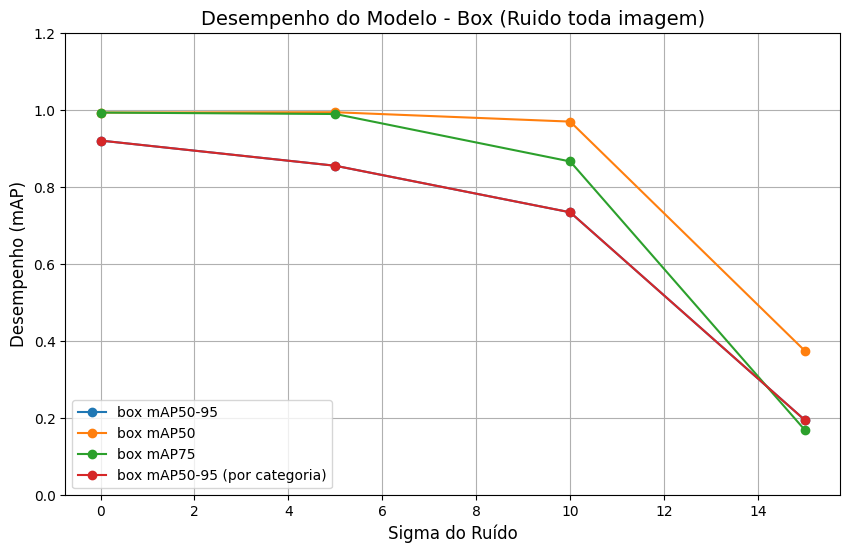

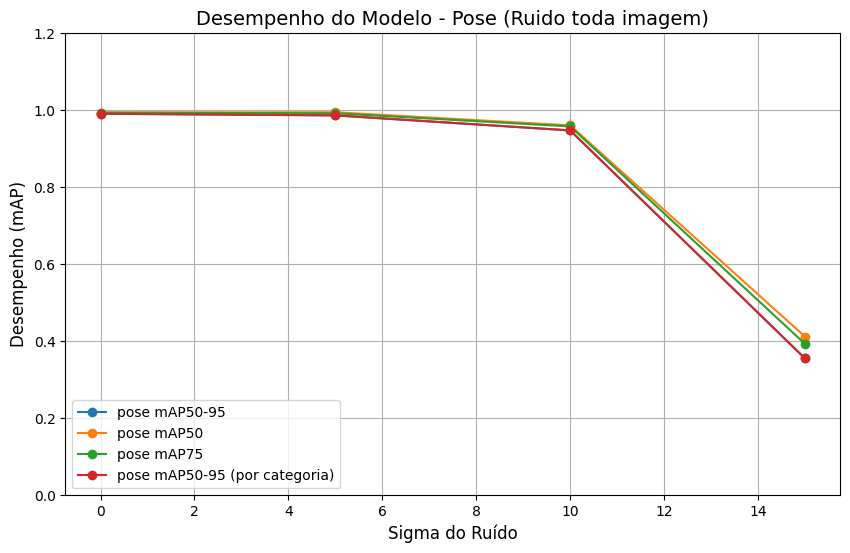

In [ ]:
# Selecionando os primeiros 4 valores
box_metrics = [metric[:4] for metric in [box_map50_95, box_map50, box_map75, box_map50_95_each]]
pose_metrics = [metric[:4] for metric in [pose_map50_95, pose_map50, pose_map75, pose_map50_95_each]]

# Chamando a função para plotar as métricas 'box' com os primeiros 4 valores
plot_multiple_metrics(
    sigmas,
    box_metrics,
    ['box mAP50-95', 'box mAP50', 'box mAP75', 'box mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Box (Ruido toda imagem)'
)

# Chamando a função para plotar as métricas 'pose' com os primeiros 4 valores
plot_multiple_metrics(
    sigmas,
    pose_metrics,
    ['pose mAP50-95', 'pose mAP50', 'pose mAP75', 'pose mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Pose (Ruido toda imagem)'
)


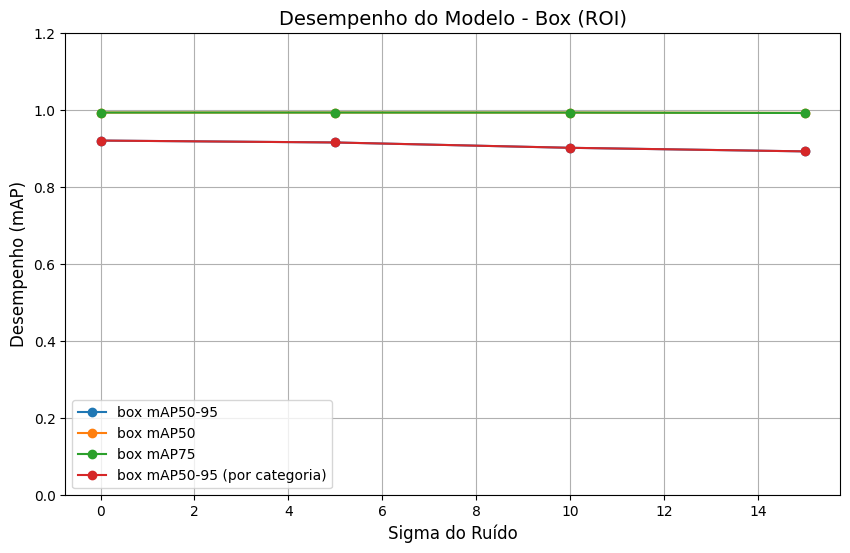

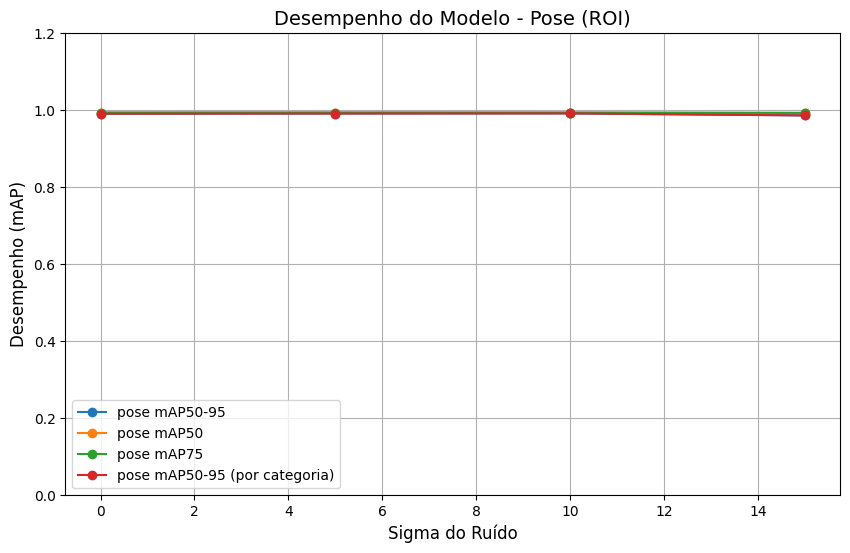

In [ ]:
# Selecionando o primeiro valor e os valores subsequentes após o 4º
box_metrics_roi = [
    [metric[0]] + metric[4:] for metric in [box_map50_95, box_map50, box_map75, box_map50_95_each]
]
pose_metrics_roi = [
    [metric[0]] + metric[4:] for metric in [pose_map50_95, pose_map50, pose_map75, pose_map50_95_each]
]

# Chamando a função para plotar as métricas 'box' com o primeiro valor e valores após o 4º
plot_multiple_metrics(
    sigmas,
    box_metrics_roi,
    ['box mAP50-95', 'box mAP50', 'box mAP75', 'box mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Box (ROI)'
)

# Chamando a função para plotar as métricas 'pose' com o primeiro valor e valores após o 4º
plot_multiple_metrics(
    sigmas,
    pose_metrics_roi,
    ['pose mAP50-95', 'pose mAP50', 'pose mAP75', 'pose mAP50-95 (por categoria)'],
    'Desempenho do Modelo - Pose (ROI)'
)
